<center><h1>Schmidt_Matteus_HW7</h1></center>
<br>
<center><font size="4"> 

**Name:** Matteus Schmidt

**GitHub:** MatteusSchmidt

**USCID:** 3780947272

</font></center>

---

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sci
import statsmodels.api as sm
import scipy

from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC

In [30]:
# Note: Jupyter env on Python 3.12

# %pip install -r ../requirements.txt

### (a) Download the Anuran Calls (MFCCs) Data Set

In [31]:
data = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')

In [32]:
print(data.head())
print(len(data))
print('missing:', data.isnull().sum())
data = data.drop(columns=['RecordID'])

   MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
0       1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945   
1       1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835   
2       1.0  0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714   
3       1.0  0.224392  0.118985  0.329432  0.372088  0.361005  0.015501   
4       1.0  0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884   

   MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_17  MFCCs_18  MFCCs_19  MFCCs_20  \
0 -0.150063 -0.171128  0.124676  ... -0.108351 -0.077623 -0.009568  0.057684   
1 -0.222475 -0.207693  0.170883  ... -0.090974 -0.056510 -0.035303  0.020140   
2 -0.242234 -0.219153  0.232538  ... -0.050691 -0.023590 -0.066722 -0.025083   
3 -0.194347 -0.098181  0.270375  ... -0.136009 -0.177037 -0.130498 -0.054766   
4 -0.265423 -0.172700  0.266434  ... -0.048885 -0.053074 -0.088550 -0.031346   

   MFCCs_21  MFCCs_22           Family      Genus         Species  R

### (b) Train a classifier for each label

#### (i) Research

Exact Match (subset accuracy) measures the percentage of samples where the predicted labels match the true labels exactly. If one label is incorrect, the entire prediction is considered incorrect. This makes it most appropriate when full label correctness is of high importance.

Hamming Score is the fraction of correctly predicted labels over all labels, computed as 1 minus the Hamming Loss. It allows for partial correctness by accounting for each label individually, making it more forgiving than exact match, but less concerned with true predictions. 

In this case, using exact match is more appropriate because the combination of family, genus, and species uniquely identifies a frog. Treating these labels independently (as in Hamming Score) wouldn't make sense as the three labels are jointly meaningful. Only a prediction that gets all three correct simultaneously should be considered accurate.

Down the line, I predict clustering will be more accurate as family, genus, species, are jointly meaningful, and most likely will be clustered in the p dimensional feature space, making KNN clustering a good option.

#### (ii) Train a SVM for each of the labels

As the data is already normalized, standardization would be like using a car crusher on a cubed jalopy.

In [36]:
gaus_results = {}
y_true = pd.DataFrame()
y_pred_all = pd.DataFrame()

param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [0.001, 0.01, 0.1, 1]
}

for label in ['Family', 'Genus', 'Species']:
    svm = OneVsRestClassifier(SVC(kernel='rbf'))

    grid_search = sci.model_selection.GridSearchCV(
        svm,
        param_grid=param_grid,
        cv=sci.model_selection.StratifiedKFold(n_splits=10),
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(data.drop(columns=['Family', 'Genus', 'Species']), data[label])
    
    y_hat = grid_search.predict(data.drop(columns=['Family', 'Genus', 'Species']))
    y_true[label] = data[label]
    y_pred_all[label] = y_hat

    print("Best parameters for", label, ":", grid_search.best_params_)
    print("Best CV accuracy for", label, ":", round(grid_search.best_score_, 4))

    gaus_results[label] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_
    }

train_EM = (y_true.values == y_pred_all.values).all(axis=1).mean()
train_HS = np.mean((y_true.values == y_pred_all.values))

print("\nExact Match Accuracy (Train) :", round(train_EM, 4))
print("Hamming Score (Train):",  round(train_HS, 4))

Best parameters for Family : {'estimator__C': 10, 'estimator__gamma': 1}
Best CV accuracy for Family : 0.8824
Best parameters for Genus : {'estimator__C': 10, 'estimator__gamma': 1}
Best CV accuracy for Genus : 0.9436
Best parameters for Species : {'estimator__C': 10, 'estimator__gamma': 1}
Best CV accuracy for Species : 0.981

Exact Match Accuracy (Train) : 0.9981
Hamming Score (Train): 0.9987


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [ ]:
print_results = ''
lasso_results = {}
y_true = pd.DataFrame()
y_pred_all = pd.DataFrame()

param_grid = {
    'estimator__C': [1, 10, 50, 100, 200]
}


for label in ['Family', 'Genus', 'Species']:
    l1_svm = OneVsRestClassifier(LinearSVC(penalty='l1', dual=False, max_iter=4000))

    grid_search = sci.model_selection.GridSearchCV(
        l1_svm,
        param_grid=param_grid,
        cv=sci.model_selection.StratifiedKFold(n_splits=10),
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(data.drop(columns=['Family', 'Genus', 'Species']), data[label])
    
    y_hat = grid_search.predict(data.drop(columns=['Family', 'Genus', 'Species']))
    y_true[label] = data[label]
    y_pred_all[label] = y_hat

    print_results = print_results + "\nBest parameters for " + str(label) + " : " + str(grid_search.best_params_)
    print_results = print_results + "\nBest CV accuracy for " + str(label) + " : " + str(round(grid_search.best_score_, 4))

    lasso_results[label] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_
    }

EM = (y_true.values == y_pred_all.values).all(axis=1).mean()
HS = np.mean((y_true.values == y_pred_all.values))

print(print_results)

print("\nExact Match Accuracy:", round(EM, 4))
print("Hamming Score:",  round(HS, 4))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increas


Best parameters for Family : {'estimator__C': 1}
Best CV accuracy forFamily : 0.846
Best parameters for Genus : {'estimator__C': 50}
Best CV accuracy forGenus : 0.8991
Best parameters for Species : {'estimator__C': 200}
Best CV accuracy forSpecies : 0.9382

Exact Match Accuracy: 0.919
Hamming Score: 0.9508


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance (class weighting)

In [44]:
print_results = ''
lasso_results = {}
y_true = pd.DataFrame()
y_pred_all = pd.DataFrame()

param_grid = {
    'estimator__C': [1, 10, 50, 100, 200],
}

for label in ['Family', 'Genus', 'Species']:
    l1_svm = OneVsRestClassifier(LinearSVC(class_weight='balanced', penalty='l1', dual=False, max_iter=4000))

    grid_search = sci.model_selection.GridSearchCV(
        l1_svm,
        param_grid=param_grid,
        cv=sci.model_selection.StratifiedKFold(n_splits=10),
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(data.drop(columns=['Family', 'Genus', 'Species']), data[label])
    
    y_hat = grid_search.predict(data.drop(columns=['Family', 'Genus', 'Species']))
    y_true[label] = data[label]
    y_pred_all[label] = y_hat

    print_results = print_results + "\nBest parameters for " + str(label) + " : " + str(grid_search.best_params_)
    print_results = print_results + "\nBest CV accuracy for " + str(label) + " : " + str(round(grid_search.best_score_, 4))

    lasso_results[label] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_
    }

EM = (y_true.values == y_pred_all.values).all(axis=1).mean()
HS = np.mean((y_true.values == y_pred_all.values))

print(print_results)

print("\nExact Match Accuracy:", round(EM, 4))
print("Hamming Score:",  round(HS, 4))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increas


Best parameters for Family : {'estimator__C': 50}
Best CV accuracy for Family : 0.839
Best parameters for Genus : {'estimator__C': 50}
Best CV accuracy for Genus : 0.8655
Best parameters for Species : {'estimator__C': 100}
Best CV accuracy for Species : 0.9286

Exact Match Accuracy: 0.9005
Hamming Score: 0.9419


The cv performance and training accuracies for models in questions 2-4 performed progressively worse. The LASSO penalty likely oversimplified the decision boundaries per class, whereas the nonlinear gaussian kernals likely made the decision boundaries a tighter fit. Applying class weightings to the linear SVM did not help and likely overcompensated for minority labels, making the model not only overpenalized on the feature set, but also on the different classes, making it further underfit.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

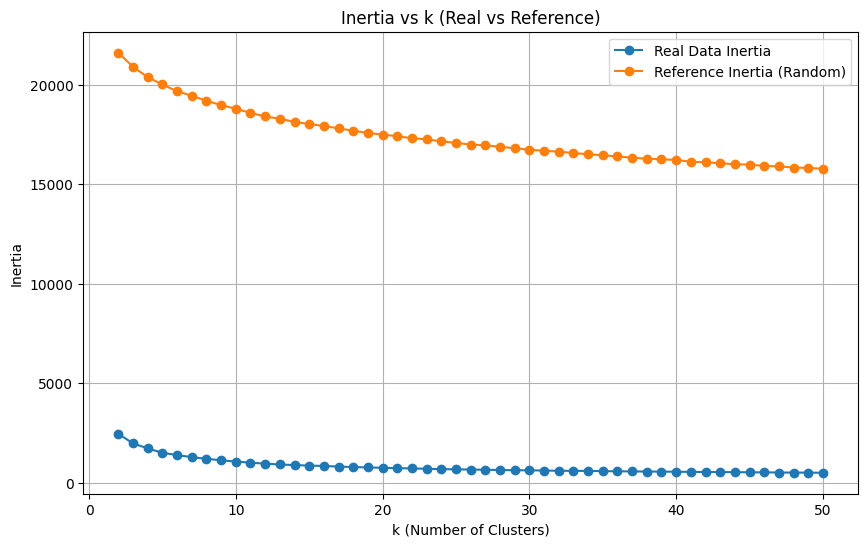

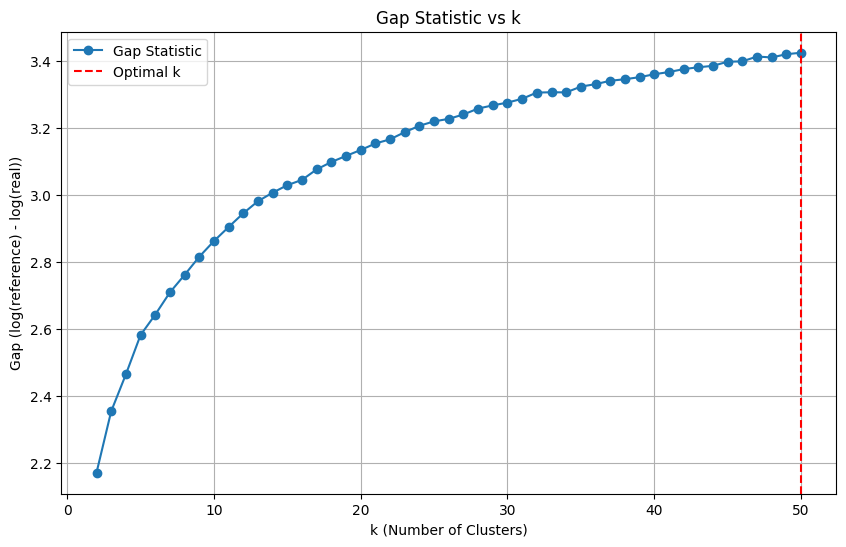

In [57]:
# calculate inertia
def inertia(feature_set, k):
    clust = sci.cluster.KMeans(n_clusters=k, n_init=15)
    clust.fit(feature_set)
    return (clust.inertia_, k)

tup_list = []
for i in range(2, 51):
    tup_list.append(inertia(data.drop(columns=['Family', 'Genus', 'Species']), i))

inertias, ks = zip(*tup_list)

# cap stat
rand_list = []
for k in range(2, 51):
    ref_inertias = []
    for _ in range(10):
        x = data.drop(columns=['Family', 'Genus', 'Species'])
        x_ref = np.random.uniform(x.min(axis=0), x.max(axis=0), size=x.shape)
        ref_inertias.append(inertia(x_ref, k))

    rand_list.append(np.mean([t[0] for t in ref_inertias]))

gaps = np.log(rand_list) - np.log(inertias)

plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, marker='o', label='Real Data Inertia')
plt.plot(ks, rand_list, marker='o', label='Reference Inertia (Random)')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.title('Inertia vs k (Real vs Reference)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ks, gaps, marker='o', label='Gap Statistic')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Gap (log(reference) - log(real))')
plt.title('Gap Statistic vs k')
plt.axvline(x=ks[np.argmax(gaps)], color='r', linestyle='--', label='Optimal k')
plt.legend()
plt.grid(True)
plt.show()

Based off of this gap statistic computation, the optimal number of clusters (or k), is 50.

In [59]:
model = sci.cluster.KMeans(n_clusters=50, n_init=15)
model.fit(data.drop(columns=['Family', 'Genus', 'Species']))

KMeans(n_clusters=50, n_init=15)

### (b) Determine which family is the majority

In [60]:
data['Cluster'] = model.labels_

def majority_labels(data, label_column):
    majority_dict = {}
    for cluster_id in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster_id]
        most_common_label = cluster_data[label_column].value_counts().idxmax()
        majority_dict[cluster_id] = most_common_label
    return majority_dict

family_majority = majority_labels(data, 'Family')
genus_majority = majority_labels(data, 'Genus')
species_majority = majority_labels(data, 'Species')

data['Family_pred'] = data['Cluster'].map(family_majority)
data['Genus_pred'] = data['Cluster'].map(genus_majority)
data['Species_pred'] = data['Cluster'].map(species_majority)

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [ ]:
true_labels = data[['Family', 'Genus', 'Species']]
pred_labels = data[['Family_pred', 'Genus_pred', 'Species_pred']]
pred_labels.columns = ['Family', 'Genus', 'Species']

hamming_distance = (true_labels != pred_labels).sum(axis=1)

hamming_loss = (hamming_distance / true_labels.shape[1]).mean()
hamming_score = ((true_labels == pred_labels).sum(axis=1) / true_labels.shape[1]).mean()
mean_hamming_distance = hamming_distance.mean()

print(f"Hamming Loss:  {hamming_loss:.4f}")
print(f"Hamming Score: {hamming_score:.4f}")
print(f"Mean Hamming Distance: {mean_hamming_distance:.4f}")

Hamming Loss:  0.0445
Hamming Score: 0.9555
Mean Hamming Distance: 0.1336


### Monte-Carlo Simulation

In [64]:
data = data.drop(columns=['Cluster', 'Family_pred', 'Genus_pred', 'Species_pred'])

hd_means = []

for _ in range(1,51):
    model = sci.cluster.KMeans(n_clusters=50, n_init=15)
    model.fit(data.drop(columns=['Family', 'Genus', 'Species']))

    # ----------------- #

    data['Cluster'] = model.labels_

    family_majority = majority_labels(data, 'Family')
    genus_majority = majority_labels(data, 'Genus')
    species_majority = majority_labels(data, 'Species')

    data['Family_pred'] = data['Cluster'].map(family_majority)
    data['Genus_pred'] = data['Cluster'].map(genus_majority)
    data['Species_pred'] = data['Cluster'].map(species_majority)

    # ----------------- #

    true_labels = data[['Family', 'Genus', 'Species']]
    pred_labels = data[['Family_pred', 'Genus_pred', 'Species_pred']]
    pred_labels.columns = ['Family', 'Genus', 'Species']

    hamming_distance = (true_labels != pred_labels).sum(axis=1)
    mean_hamming_distance = hamming_distance.mean()
    hd_means.append(mean_hamming_distance)

    data = data.drop(columns=['Cluster', 'Family_pred', 'Genus_pred', 'Species_pred'])

print('Monte Carlo sim Hamming Distance mean:', np.mean(hd_means))
print('Monte Carlo sim Hamming Distance std:', np.std(hd_means))

Monte Carlo sim Hamming Distance mean: 0.1317359277275886
Monte Carlo sim Hamming Distance std: 0.007761876924054456


## 3. ISLR 12.6.2

![image](../images/12.6.2.png)